In [6]:
import numpy as np
from scipy import fftpack
from skimage.metrics import peak_signal_noise_ratio as psnr 

In [7]:
class similarity_method:
    def __init__(self , method="fullsearch"):
        self.method = method
        


    def similarity(self, im , block):
        # print("simmmm ",self.method == "fullsearch",self.method ,  "fullsearch" )
        if self.method == "fullsearch":
            return self.fullsearch(im , block)


    def fullsearch(self, im , block):
        max_psnr = -1
        maxi = -1
        maxj = -1
        diff =  block - block
        bsize = block.shape[0]
        for i in range(0 , im.shape[0]-bsize , 3):
            print( max_psnr)
            for j in range(0 , im.shape[1] - bsize , 3):
                s = psnr(im[i:i+bsize , j:j+bsize] , block)
                if s  >= max_psnr:
                    max_psnr = s
                    maxi = i
                    maxj = j
                    diff =  block  -  im[i:i+bsize , j:j+bsize] 
                    
        return diff , [maxi , maxj]   # return upper left corner 






class encoder:




    def __init__(self ,video ,search_method="fullsearch" ,   mb_size = 16 , alpha=1 ):
        self.iframe = video[0]
        self.pframes = video[1:]
        self.mb_size = mb_size
        self.alpha = alpha
        self.sim_method = similarity_method(method=search_method)

        QUANTIZATION_MATRIX =np.array([
            [16 ,  11 ,   10 ,   16 ,   24 ,   40 ,   51 ,  61],
            [12  , 12  ,  14  ,  19  ,  26  ,  58  ,  60  , 55],
            [14  , 13  ,  16  ,  24  ,  40  ,  57  ,  69  , 56],
            [14  , 17  ,  22  ,  29  ,  51  ,  87  ,  80  , 62],
            [18  , 22  ,  37  ,  56  ,  68  , 109  , 103  , 77],
            [24  , 35  ,  55  ,  64  ,  81  , 104  , 113  , 92],
            [49  , 64  ,  78  ,  87  , 103  , 121  , 120  ,101],
            [72  , 92  ,  95  ,  98  , 112  , 100  , 103  , 99]
                ])

        tmp = np.zeros((8,8,3))
        tmp[:,:,0] , tmp[:,:,1] ,tmp[:,:,2] = QUANTIZATION_MATRIX,QUANTIZATION_MATRIX,QUANTIZATION_MATRIX
        self.QUANTIZATION_MATRIX = tmp

    def blocking(self, im , blockSize):
        blocks = []
        for i in range(blockSize , im.shape[0]+1 ,blockSize):
            for j in range(blockSize ,im.shape[1]+1 , blockSize):
                B = im[i-blockSize:i , j-blockSize:j]
                blocks.append(B)

        blocks = np.array(blocks)
        return blocks


    def rgb2ycbcr(self , im):
        xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
        ycbcr = im.dot(xform.T)
        ycbcr[:,:,[1,2]] += 128
        return np.uint8(ycbcr)


    def dct(self , a):
        return fftpack.dct( fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )



    def iframe_coding(self):
        mbs = self.blocking(self.iframe , 8)
        coded = np.zeros(mbs.shape)
        for i in range(mbs.shape[0]):
            coded[i] = self.dct(self.rgb2ycbcr(mbs[i]))  /  (self.QUANTIZATION_MATRIX * self.alpha)
        return coded.astype(int)

    

    def pframe_coding(self , frame , prev_reco_frame):
        mbs = self.blocking(frame , 16)
        motion_vectors = []
        diffrences = []
        # print("@@@@@@@@@@@@@" , mbs.shape)
        for i in range(mbs.shape[0]):
            dif , mv = self.sim_method.similarity( prev_reco_frame , mbs[i])
            tmp = self.blocking(dif , 8)  
            a = self.dct(tmp[0] ) /  (self.QUANTIZATION_MATRIX * self.alpha)
            b = self.dct(tmp[1])  /  (self.QUANTIZATION_MATRIX * self.alpha)
            c = self.dct(tmp[2])  /  (self.QUANTIZATION_MATRIX * self.alpha)
            d = self.dct(tmp[3])  /  (self.QUANTIZATION_MATRIX * self.alpha)
            diffrences.append([a,b,c,d])
            motion_vectors.append(mv)
        diffrences = np.array(diffrences)
        motion_vectors = np.array(motion_vectors)

        return diffrences , motion_vectors


        




            



        
        






In [23]:
class decoder:
    def __init__(self , alpha = 1 , targetSize=(256, 256)):
        self.alpha = alpha
        self.targetSize = targetSize
        QUANTIZATION_MATRIX =np.array([
            [16 ,  11 ,   10 ,   16 ,   24 ,   40 ,   51 ,  61],
            [12  , 12  ,  14  ,  19  ,  26  ,  58  ,  60  , 55],
            [14  , 13  ,  16  ,  24  ,  40  ,  57  ,  69  , 56],
            [14  , 17  ,  22  ,  29  ,  51  ,  87  ,  80  , 62],
            [18  , 22  ,  37  ,  56  ,  68  , 109  , 103  , 77],
            [24  , 35  ,  55  ,  64  ,  81  , 104  , 113  , 92],
            [49  , 64  ,  78  ,  87  , 103  , 121  , 120  ,101],
            [72  , 92  ,  95  ,  98  , 112  , 100  , 103  , 99]
                ])

        tmp = np.zeros((8,8,3))
        tmp[:,:,0] , tmp[:,:,1] ,tmp[:,:,2] = QUANTIZATION_MATRIX,QUANTIZATION_MATRIX,QUANTIZATION_MATRIX
        self.QUANTIZATION_MATRIX = tmp

    def func1(self):
        print('hi')

    def ycbcr2rgb(self,im):
        xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
        rgb = im.astype(np.float)
        rgb[:,:,[1,2]] -= 128
        rgb = rgb.dot(xform.T)
        np.putmask(rgb, rgb > 255, 255)
        np.putmask(rgb, rgb < 0, 0)
        return np.uint8(rgb)

    def idct(self , a):
        return fftpack.idct( fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')


    def reconstructFromBlocks(self , blocks , targetShape = (265,256) , blockSize = 16):
        numOfBlockInCol = int(targetShape[0] / blockSize)
        numOfBlockInRow = int(targetShape[1] / blockSize)

        recoIMG = np.array([])
        
        count = -1 

        for i in range( numOfBlockInCol):
            recoRow = np.array([])
            for j in range(numOfBlockInRow):
                count += 1
                if recoRow.size == 0:
                    recoRow = blocks[i * numOfBlockInRow]
                else:
                    recoRow = np.hstack((recoRow,blocks[count]))
            
            if recoIMG.size == 0:
                recoIMG = recoRow
            else:
                recoIMG = np.vstack((recoIMG,recoRow))

        return recoIMG


    def iframe_decoding(self , coded):
        decoded = np.zeros(coded.shape)
        for i in range(coded.shape[0]):
            tmp = coded[i] * (self.QUANTIZATION_MATRIX * self.alpha)
            # print(tmp.shape)
            decoded[i] = self.ycbcr2rgb(self.idct(tmp))
        # print(decoded.shape, "&&&&&&&&&&&&&&&&")
        return  self.reconstructFromBlocks( decoded , targetShape = self.targetSize , blockSize = 8).astype("uint8")


    def pframe_decoding(self , prev_frame , diffrences , motion_vectors):
        reco_mbs = []
        for i in range(diffrences.shape[0]):
            aa = np.hstack((self.idct(diffrences[i,0] * (self.QUANTIZATION_MATRIX * self.alpha)) , self.idct(diffrences[i,1]* (self.QUANTIZATION_MATRIX * self.alpha))))
            bb = np.hstack((self.idct(diffrences[i,2] * (self.QUANTIZATION_MATRIX * self.alpha)) , self.idct(diffrences[i,3]* (self.QUANTIZATION_MATRIX * self.alpha))))
            mb_diff = np.vstack(((aa) , (bb)))
            # print(motion_vectors[i,0] , mb_diff.shape[0]+motion_vectors[i,0] , motion_vectors[i,1],mb_diff.shape[1]+motion_vectors[i,1])
            tmp = mb_diff + prev_frame[motion_vectors[i,0]:mb_diff.shape[0]+motion_vectors[i,0] , motion_vectors[i,1]:mb_diff.shape[1]+motion_vectors[i,1]]
            reco_mbs.append(tmp)

        return  self.reconstructFromBlocks( reco_mbs , targetShape = self.targetSize , blockSize = 16).astype("uint8")
        
            


In [24]:
import skvideo as vi
import skvideo.io
import skvideo.motion
import skvideo.measure
import skvideo.datasets
import matplotlib.pyplot as plt


raw_suzie = vi.io.vread("suzie_qcif.y4m",as_grey=False)

print(raw_suzie.shape)

(150, 144, 176, 3)


In [25]:
enc = encoder(raw_suzie ,search_method="fullsearch" , mb_size=16)
codedd = enc.iframe_coding()

# a = enc.rgb2ycbcr(raw_suzie[0])
codedd.shape

initttttttt


(396, 8, 8, 3)

In [26]:
decoder1 = decoder(targetSize=(144,176))

decodedIframe = decoder1.iframe_decoding(codedd)


C:\Users\Farhad\AppData\Local\Temp\ipykernel_13752\888410329.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = im.astype(np.float)


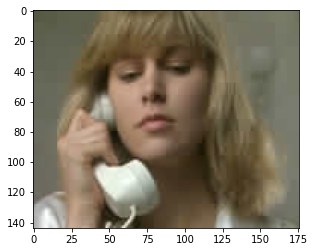

In [27]:
plt.imshow(decodedIframe)

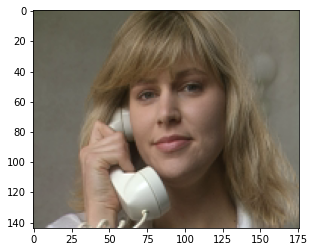

In [28]:
plt.imshow(raw_suzie[100] )

In [29]:
coded_pframe = enc.pframe_coding(raw_suzie[100] , decodedIframe)

@@@@@@@@@@@@@ (99, 16, 16, 3)
^^^^^XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXx^^   128 160
-1
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
39.53913907426856
^^^^^XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXx^^   128 160
-1
39.08438060508933
39.811039981755584
40.239478636030725
40.31830012480392
40.318

In [30]:
coded_pframe[0].shape

(99, 4, 8, 8, 3)

In [31]:
decoded_pframe = decoder1.pframe_decoding(decodedIframe , coded_pframe[0] , coded_pframe[1])

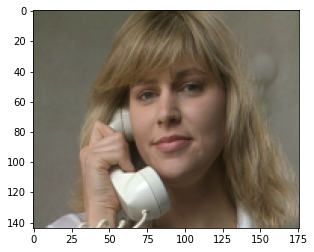

In [32]:
plt.imshow(decoded_pframe)

In [33]:
psnr(decoded_pframe , raw_suzie[100])

58.47987195138988